In [1]:

import mne

file = "physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


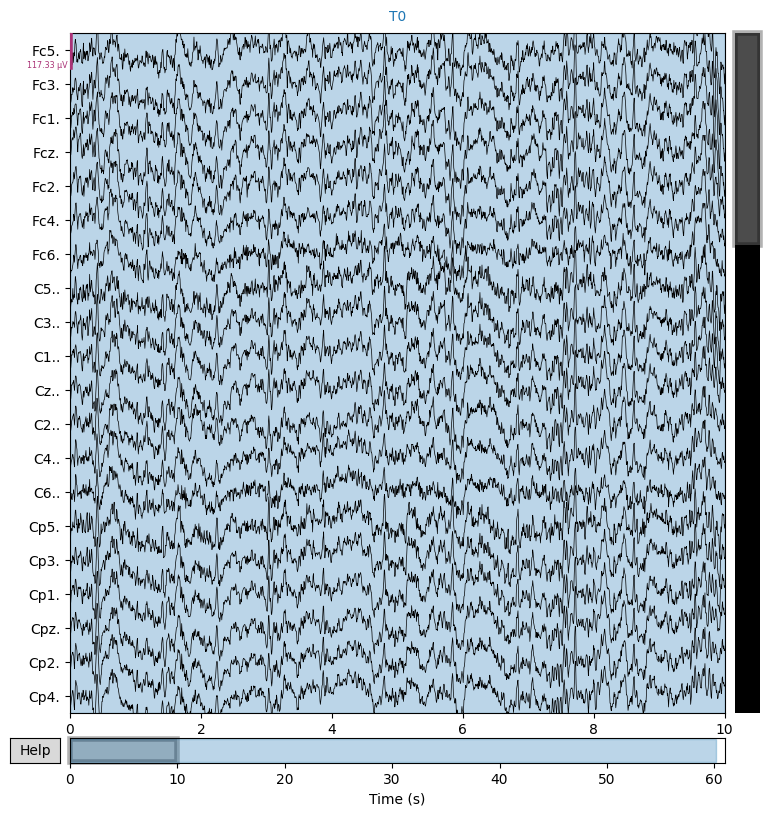

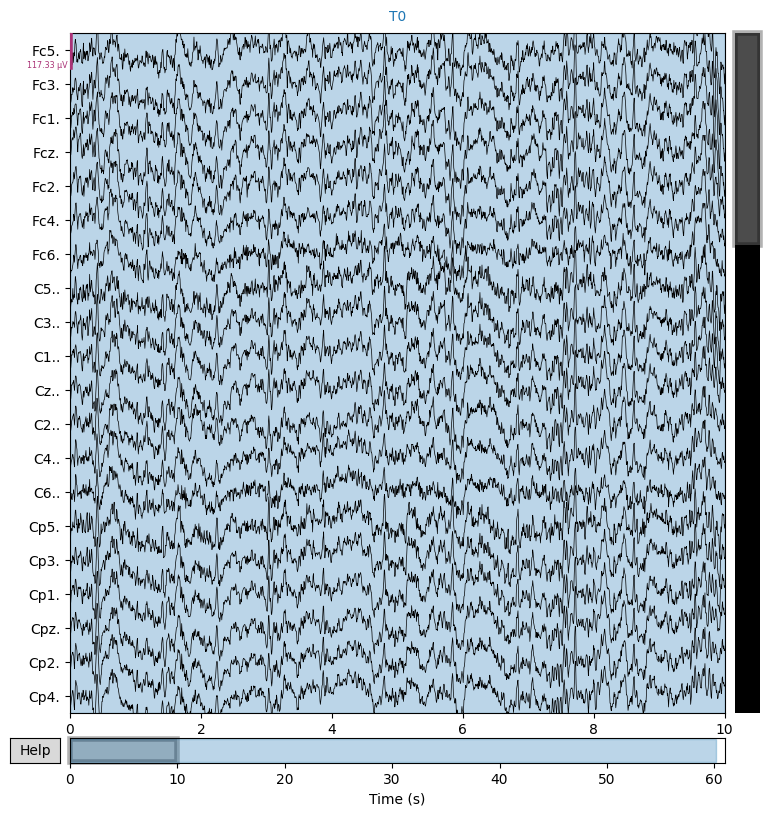

In [8]:
data.plot(scalings='auto', title='Data from arrays')

In [12]:
file = "physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf.event"
data = mne.read_events(file)


/tmp/ipykernel_26157/84980687.py:2: RuntimeWarning: This filename (physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf.event) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  data = mne.read_events(file)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 3: invalid start byte